## Model Selection

___

*Source: [James et al., An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) *

___


Now, we have a zoo of performance measures, we have discussed that we should avoid to optimize our models and its hyperparameters only on a subset of observations (i.e. the *training set*), but we should use the *testing set* only to asses the final performance of the *model*.

In this notebook we'll see how to estimate the *test accuracy* (or any other model performance measure) leveraging only on the *training set* and, as a consequence, how to find a right **bias - variance tradeoff** while searching the right model and the right *hyper parameters*.

### Validation Set Approach
The first simple way to estimate the *test error* from the *training set* is to split it in two subsets:
* The **real** *training set* on which the model is fitted.
* A *validation set* used to estimate the *test error*

Let's try this simple strategy on the titanic dataset, but first let's fit this dataset using **KKNN** with $k = 5$ on the whole *training set* and compute the *training error* and the *test error*

In [1]:
source("src/lib.R")
source("src/titanic/titanic_dataset.R")

titanic_df <- get_titanic_df()

model <-  train(
    y = titanic_df$y_train$class,
    x = titanic_df$x_train,
    method = "kknn",
    ks = 5,
    trControl = trainControl(classProbs =  TRUE, method = "none"),
    tuneGrid = data.frame(
          kmax = 1,
          distance = 2,
          kernel = 'rectangular'
      )
)

(full_train_error <- confusionMatrix(predict(model, titanic_df$x_train), titanic_df$y_train$class)$overall["Accuracy"])
(full_test_error <- confusionMatrix(predict(model, titanic_df$x_test), titanic_df$y_test$class)$overall["Accuracy"])

Accuracy 
0.8409586

Accuracy 
0.7704082

Now let's use **CARET** to directly estimate the *test error* using the *validation set* approach:

In [2]:
## Let's split the training set in two partitions of equal size
set.seed(29)
full_indices <- 1:nrow(titanic_df$x_train)
validation_set <- sample(full_indices, length(full_indices) / 2)
small_train_set <- full_indices[!(full_indices %in% validation_set)]

## Let's instruct CARET to use the small_train_set to estimate the accuracy and the validation_set to train it
model <-  train(
  y = titanic_df$y_train$class,
  x = titanic_df$x_train,
  method = "kknn",
  ks = 5,
  trControl = trainControl(
    classProbs =  TRUE, 
    method = "cv",
    index = list(sample = small_train_set),
    indexOut = list(sample = validation_set),
    indexFinal = small_train_set
  ),
  tuneGrid = data.frame(
    kmax = 1,
    distance = 2,
    kernel = 'rectangular'
  )
)

## Compute the accuracy on the small train set and on validation
confusionMatrix(predict(model, titanic_df$x_train[small_train_set,]), titanic_df$y_train[small_train_set,]$class)$overall["Accuracy"]
confusionMatrix(predict(model, titanic_df$x_train[validation_set,]), titanic_df$y_train[validation_set,]$class)$overall["Accuracy"]

Accuracy 
0.8562092

Accuracy 
0.7821351

It worked! The estimation of our *testing error* is 0.79 nearer to the real value of 0.77 than 0.84. Note that this same measure can be directly extracted from the *train* function output:

In [3]:
model$results$Accuracy

[1] 0.7821351

Ok...we have found a way to estimate the *testing error*...how good is this estimation varying $K$?

In [4]:
res_df <- data_frame()
for(k in seq(1,25)) {
  model <-  train(
    y = titanic_df$y_train$class,
    x = titanic_df$x_train,
    method = "kknn",
    ks = k,
    trControl = trainControl(
      classProbs =  TRUE, 
      method = "cv",
      index = list(sample = small_train_set),
      indexOut = list(sample = validation_set)
    ),
    tuneGrid = data.frame(
      kmax = 1,
      distance = 2,
      kernel = 'rectangular'
    )
  )
  res_df <- rbind(
    res_df,
    data_frame(
      k = k, 
      validation_error = model$results$Accuracy, 
      test_error = confusionMatrix(predict(model, titanic_df$x_test), titanic_df$y_test$class)$overall["Accuracy"],
      train_error = confusionMatrix(predict(model, titanic_df$x_train), titanic_df$y_train$class)$overall["Accuracy"],
    )
  )
}

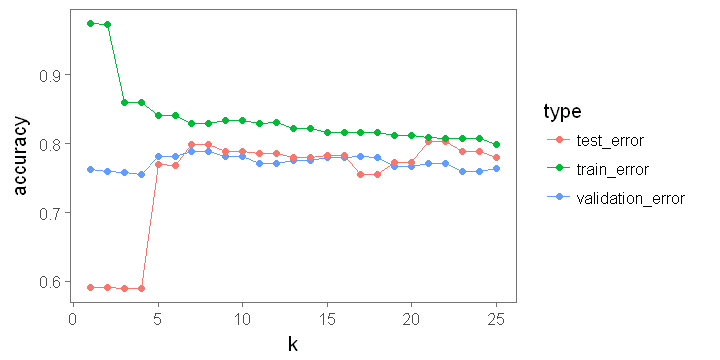

In [5]:
options(repr.plot.width=6, repr.plot.height=3) ### set a small plot size

res_df %>% gather(type, accuracy, -k) %>%
  ggplot(aes(x = k, y = accuracy, color = type)) +
  geom_line() + geom_point() + theme_few()

It really depends on the $k$ but the *validation set* error sometimes overstimates the *testing error* (or understimate the accuracy).

So...end of the story? Can we do any better?

The *validation test* approach in *test error* estimation has two main drawbacks.

* The *validation set error* is computed on a model fitted only on a part of the *training set* and, since a model fitted on more data should have lower *test error*, the *validation set error* may **overestimate** the *test error*
* The *validation set error* strongly depends on the way in which the *validation set* is selected.

On the second point, let's see what happens when we change the *validation set*:

In [6]:
multi_res_df <- data_frame()
for(attempt in 1:10) {  
  validation_set <- sample(full_indices, length(full_indices) / 2)
  small_train_set <- full_indices[!(full_indices %in% validation_set)]
  for(k in seq(1,25,2)) {
    model <-  train(
      y = titanic_df$y_train$class,
      x = titanic_df$x_train,
      method = "kknn",
      ks = k,
      trControl = trainControl(
        classProbs =  TRUE, 
        method = "cv",
        index = list(sample = small_train_set),
        indexOut = list(sample = validation_set)
      ),
      tuneGrid = data.frame(
        kmax = 1,
        distance = 2,
        kernel = 'rectangular'
      )
    )
    multi_res_df <- rbind(
      multi_res_df,
      data_frame(
        k = k,
        attempt = attempt,
        accuracy = model$results$Accuracy, 
      )
    )
  }
}


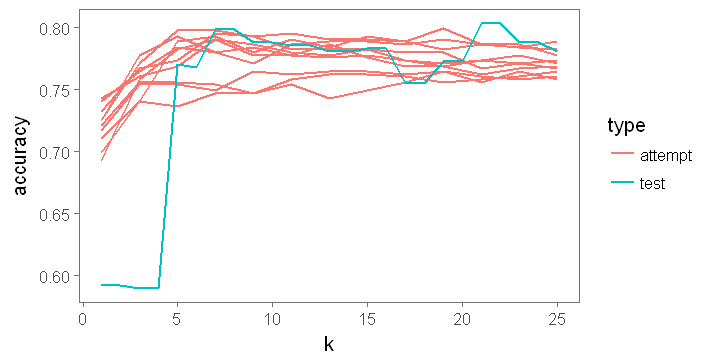

In [7]:
multi_res_df %>% mutate(attempt = str_c("attempt_", attempt)) %>%
  rbind(res_df %>% select(k,accuracy = test_error) %>% mutate(attempt = "test")) %>%
  mutate(type = ifelse(attempt == "test", "test", "attempt")) %>%
  ggplot(aes(x = k, y = accuracy, color = type, group = attempt)) +
  geom_line(size = 0.8) + theme_few()

### Cross Validation

Cross Validation (aka CV) is a set of computing intensive techniques that allow to estimate the *test error* in more robust way w.r.t. the *validation set* approach.

#### Leave one out Cross Validation

The *Leave One Out Cross Validation* (aka LOOCV) estimation process is an iterative extension of the *validation set approach*:

* From the training set $\left\{ (x_1,y_1), (x_2,y_2), \dots, (x_n,y_n) \right\}$ set aside one single observation $(x_i,y_i)$.
* Asses the performance of the model (with, as example, accuracy) using the left out observation $(x_i,y_i)$, and call this measure $A_i$
* Iterate the process on all the *training set* observations, obtaining the set of performance measures $\left\{ A_1, A_2, \dots, A_n \right\}$
* Estimate the *test error* as:
$$\frac{1}{n} \sum_{i = 1}^n A_i$$




This method solves the two main drawbacks of the *validation set* approach:

* Each $A_i$ is compute on model fitted on almost all the *training set* observations.
* There is no arbitrarity or randomness in the process

Morever LOOCV is a built-in validation strategy in **CARET**:

In [8]:
system.time(
model <-  train(
  y = titanic_df$y_train$class,
  x = titanic_df$x_train,
  method = "kknn",
  ks = 5,
  trControl = trainControl(
    classProbs =  TRUE, 
    method = "LOOCV"
    #,verboseIter = T
  ),
  tuneGrid = data.frame(
    kmax = 1,
    distance = 2,
    kernel = 'rectangular'
  )
)
)

   user  system elapsed 
  57.00    0.00   57.02 

In [9]:
model$results$Accuracy
(full_test_error <- confusionMatrix(predict(model, titanic_df$x_test), titanic_df$y_test$class)$overall["Accuracy"])

[1] 0.7854031

Accuracy 
0.7704082

Any drawback? 

The **computational requirements**: we need to fit $n$ models where $n$ is the set of observations in the *training set*!

On small datasets this is not a problem....but we want to work with **BIG DATA!**

P.S. there are some models in which the *LOOCV test error estimation* can be efficiently computed (i.e. *Linear Regression*)

#### K-Fold validation

In order to maintain the benefits of *LOOCV* but with less computational burden we can use the *K-Fold validation* approach:
* **Randomly** split the *training set* in $k$ equal (or almost equal) parts.
  $$\left\{ F_1,\dots,F_k \right\}$$
* For each fold $F_i$, fit the model on all the points in the *training set* with the exception of the points in $F_i$ and Compute the *accuracy* of the fitted model on $F_i$ and call it $A_i.
* Estimate the *testing error* as:
    $$\frac{1}{k} \sum_{i=1}^k A_i$$

Here we are reintroducing the *randomness* in the process but averaging *k* attempts we will significatly reduce the variability in the estimation process. Note that when $k=n$ we go back to the *LOOCV*.

Let's this in practice with **CARET** (here a way to do a *10-fold* cross validation):

In [10]:
system.time(
model <-  train(
  y = titanic_df$y_train$class,
  x = titanic_df$x_train,
  method = "kknn",
  ks = 5,
  trControl = trainControl(
    classProbs =  TRUE, 
    method = "cv",
    number = 10
    #,verboseIter = T
  ),
  tuneGrid = data.frame(
    kmax = 1,
    distance = 2,
    kernel = 'rectangular'
  )
)
)

model$results$Accuracy

   user  system elapsed 
   1.23    0.00    1.24 

[1] 0.7821667

So...a similar accuracy estimation but a fraction (1s vs. 60s on my machin) of the computational effort. Let's what happens we a repeated estimation procedure:

In [11]:
k_fold_res_df <- data_frame()
for(attempt in 1:10) {  
  validation_set <- sample(full_indices, length(full_indices) / 2)
  small_train_set <- full_indices[!(full_indices %in% validation_set)]
  for(k in seq(1,25,2)) {
    model <-  train(
      y = titanic_df$y_train$class,
      x = titanic_df$x_train,
      method = "kknn",
      ks = k,
      trControl = trainControl(
        classProbs =  TRUE, 
        method = "cv",
        number = 10
      ),
      tuneGrid = data.frame(
        kmax = 1,
        distance = 2,
        kernel = 'rectangular'
      )
    )
    k_fold_res_df <- rbind(
      k_fold_res_df,
      data_frame(
        k = k,
        attempt = attempt,
        accuracy = model$results$Accuracy, 
      )
    )
  }
}

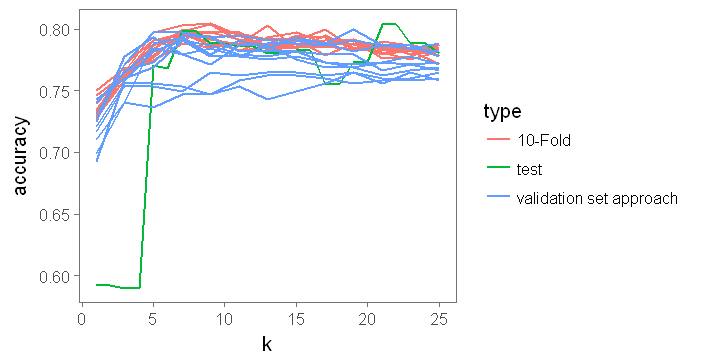

In [12]:
multi_res_df %>% mutate(attempt = str_c("VS ", attempt)) %>%
  rbind(res_df %>% select(k,accuracy = test_error) %>% mutate(attempt = "test")) %>%
  mutate(type = ifelse(attempt == "test", "test", "validation set approach")) %>%
  rbind(k_fold_res_df %>% mutate(type = "10-Fold") %>% mutate(attempt = str_c("KF ", attempt))) %>%
  ggplot(aes(x = k, y = accuracy, color = type, group = attempt)) +
  geom_line(size = 0.8) + theme_few()

Another advantage of the *K-Fold validation* w.r.t. to the *LOOCV* is linked with the *Bias-Variance tradeoff*, using the *LOOCV* we fit *n* models on almost identical dataset and as a consequence the fitted models are highly positive correlated. As a consequence the *test error* estimation derived from *LOOCV* has a high *variance* w.r.t. the one derived from the *K-Fold validation* when K is small enough.

#### Ensembling

In [21]:
model$results

kmax,distance,kernel,Accuracy,Kappa,AccuracySD,KappaSD
1,2,rectangular,0.792893,0.5626414,0.05663257,0.1112675
